# Try training the model using labels that are either 1 or 0, not in between
 - *not discussed in the paper* since it didn't work at all
 - we had wondered if the "confusion" in the dataset contributed to the BCE loss not properly penalizing guesses that were in between.
 - only difference between here and the grid search notebooks is basically using `labels = np.round(labels).to(device)` in the train loop (the rounding)

 

In [6]:
import numpy as np
import IPython.display as ipd
import json
import glob
import time
import copy
import pickle

from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torch

import matplotlib.pyplot as plt
from tqdm import tqdm 

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

In [7]:
with np.load("../openmic-2018/openmic-2018.npz", allow_pickle=True) as data:
    files = data.files
    print(files)
    X = data['X']
    Y_true = data['Y_true']
    Y_mask = data['Y_mask']
    sample_key = data['sample_key']
    
with open('../openmic-2018/class-map.json') as f:
    class_map = json.load(f)
    class_map_inv = {v: k for k, v in class_map.items()}
    classes = np.array(list(class_map_inv.values()))

['X', 'Y_true', 'Y_mask', 'sample_key']


In [54]:
class IRdataset(Dataset):
    def __init__(self, instrument='voice', method='concat'):
        
        # not every sample is annotated for every instrument.
        # e.g. for a specific sample nobody might've checked whether or not 
        # there was voice. When constructing our dataset, we only
        # take samples for which the instrument's presence was annotated.
        if method == 'concat':
            fname_func = fname_to_path_concat
            feature_path = "features2/*.npy"
        elif method == 'upsample':
            fname_func = fname_to_path_upsample
            feature_path = "features/*.npy"

        self.mask = Y_mask[:, class_map[instrument]]
        self.fnames = np.array([fname_func(fname) for fname in sample_key])
        existing_files = glob.glob(feature_path)
        fname_exists_mask = np.array([x in existing_files for x in self.fnames])
        self.mask = self.mask * fname_exists_mask
        
        # 
        self.probabilities = Y_true[self.mask][:,class_map[instrument]].astype('float32')
        self.input_files = [np.load(x).astype('float32') for x in self.fnames[self.mask]]
        
    def __len__(self):
        return self.probabilities.shape[0]
        # return 100 # for debug
    
    def __getitem__(self, idx):
        return self.input_files[idx], self.probabilities[idx]
    
    def get_audio(self, idx):
        fname = sample_key[self.mask][idx]
        path = '../openmic-2018/audio/' + fname[0:3] + '/' + fname + '.ogg'
        print(path)
        return ipd.Audio(path)

In [55]:
fname_to_path_concat  = lambda fname: f"features2/{fname}.npy"
# fname_to_path_upsample = lambda fname: f"features/{fname}.npy"

def load_dl_dict(instrument='voice', method='concat'):
    with open("test_sets/" + method + "/" + instrument + ".pkl", "rb") as handle:
        dl_dict = pickle.load(handle)
    return dl_dict

def get_test_dataloader(instrument='voice', method='concat'):
    with open("test_sets/" + method + "/" + instrument + ".pkl", "rb") as handle:
        dl_dict = pickle.load(handle)
    test_dl = dl_dict['test']
    return test_dl

<BarContainer object of 100 artists>

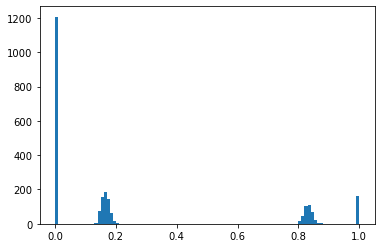

In [57]:
dataset = IRdataset('clarinet')
plt.hist(dataset.probabilities, bins=100)[2]

<BarContainer object of 100 artists>

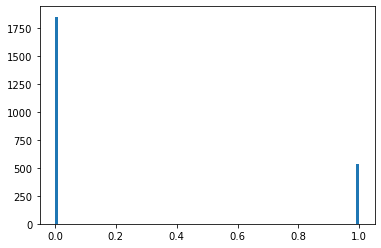

In [60]:
plt.hist([np.round(y) for x, y in dataset], bins=100)[2]

## try training

In [41]:
class BaseModel(nn.Module):
    def __init__(self, hidden_sizes=[512], p=.5):
        super(BaseModel, self).__init__()
        input_size = 4800
        self.hidden_sizes = [input_size] + hidden_sizes + [1]
        for i in range(1, len(self.hidden_sizes)):
            setattr(self, f"hidden_{i}", nn.Linear(self.hidden_sizes[i-1], self.hidden_sizes[i]))
        # self.lins = [nn.Linear(hidden_sizes[i-1], hidden_sizes[i]) for i in range(1, len(hidden_sizes))]
        self.dropout = nn.Dropout(p=p)
        
    def forward(self, x):
        x = self.dropout(x)
        for i in range(1, len(self.hidden_sizes)-1):
            x = getattr(self, f"hidden_{i}")(x)
            x = F.relu(x)
            x = self.dropout(x)
        x = getattr(self, f"hidden_{len(self.hidden_sizes)-1}")(x) # output
        return x

In [61]:
# EDITED TO ROUND LABELS!
def train_model_classifier(model, dataloaders, criterion, optimizer, num_epochs=25, display=False):
    since = time.time()
    val_acc_history = []
    train_loss_history = []
    val_loss_history = []
    best_acc = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())

    iterator = range(num_epochs) if display else tqdm(range(num_epochs))
    for epoch in iterator:
        if display:
            print('Epoch {}/{}'.format(epoch, num_epochs - 1))
            print('-' * 10)
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
            running_loss = 0.0
            running_corrects = 0
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = np.round(labels).to(device)
                # zero the parameter gradients
                optimizer.zero_grad()
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs).flatten()
                    loss = criterion(outputs, labels)
                    preds = torch.sigmoid(outputs)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(torch.round(preds).int() == torch.round(labels.data).int())
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            if display:
                print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)
                if best_acc < epoch_acc:
                    best_acc = max(epoch_acc, best_acc)
                    best_model_wts = copy.deepcopy(model.state_dict())
            else:
                train_loss_history.append(epoch_loss)

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    
    # load best model weights
    model.load_state_dict(best_model_wts)

    return model, val_acc_history, train_loss_history, val_loss_history

In [43]:
def he_initialization(m):
    """
    https://stackoverflow.com/questions/49433936/how-to-initialize-weights-in-pytorch
    """
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        torch.nn.init.kaiming_uniform_(m.weight)


def train_and_display(model, dataloader_dict, num_epochs=100, regularization=1e-4, plot=True):
    """
    run the training using gradient descent and CE loss.
    plot validation and test loss, and valiation accuracy
    """
    alpha = 1e-4
    # beta  = 0
    # regularization = 1e-4
    
    model = model.to(device)
    model.apply(he_initialization)
    #optimizer = optim.SGD(model.parameters(), lr=alpha, momentum=beta)
    optimizer = optim.Adam(model.parameters(), lr=alpha, weight_decay=regularization)
    criterion = torch.nn.BCEWithLogitsLoss()
    model, val_acc_history, train_loss_history, val_loss_history = train_model_classifier(model, 
                                                                                          dataloader_dict,
                                                                                          criterion,
                                                                                          optimizer,
                                                                                          num_epochs)
    val_acc_history = [x.cpu() for x in val_acc_history]
    
    if plot:
        fig, ax = plt.subplots()
        ax.set_title("Train and Validation Loss, Validation accuracy vs. epoch")
        ax.set_xlabel("epoch")
        ax.set_ylabel("Cross Entropy Loss")
        ax.plot(train_loss_history, label="train loss")
        ax.plot(val_loss_history, label="validation loss")
        ax.legend(loc='upper left')

        ax2 = ax.twinx()
        ax2.plot(val_acc_history, color='r', label='validation accuracy')
        ax2.set_ylabel('accuracy')
        ax2.legend(loc='upper right')
        ax2.set_ylim([0, 1.0])
    else:
        fig = None
    return model, fig, np.min(val_loss_history), val_acc_history[np.argmin(val_loss_history)]

In [50]:
def get_f1(instrument, model, dl = None):
    # model = models[instrument].to(device)
    model.eval()   # Set model to evaluate mode
    
    if dl is None:
        dl = get_test_dataloader(instrument)
    true_pos = 0
    false_pos = 0
    false_neg = 0
    for x, y in dl:
        x = x.to(device)
        outputs = model(x).flatten()
        outs = torch.sigmoid(outputs).cpu().detach().numpy()
        # print(outs)
        preds = np.round(outs).astype('int')
        true  = np.round(y.numpy().astype('int'))
        true_pos  += np.sum( preds[true==preds]*1.0)
        false_pos += np.sum((preds[true!=preds] == 1)*1.0)
        false_neg += np.sum((preds[true!=preds] == 0)*1.0)
    p = true_pos / (true_pos + false_pos)
    r = true_pos / (true_pos + false_neg)
    f1 = 2*(p * r)/(p + r)
    return f1

 ## eval

100%|██████████| 800/800 [00:23<00:00, 33.69it/s]


Training complete in 0m 24s
Best val Acc: 0.758910


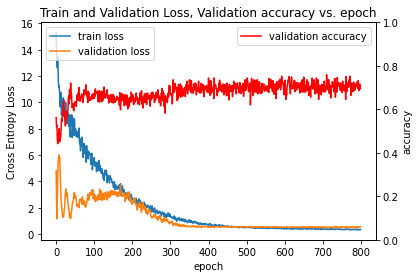

In [62]:
model=BaseModel()
dl_dict = load_dl_dict('clarinet')
model, fig, _, _ = train_and_display(model, dl_dict, num_epochs=int(8e2))

In [63]:
get_f1('clarinet', model, dl=dl_dict['test'])

0.24675324675324672